HW06 - P06

<div style="display: flex; justify-content: center;">
<h2 style="text-color:blue;"> Robotics and Mechatronics - Image Classification with CNN </h2>
</div>  

---

#### Mohammad Montazeri - 810699269

## Problem Description
In this project, we're using a dataset of different robot images categorized into Five classes: Serial Manipulator, Parallel Manipulator, Humanoid Robot, Mobile Robot and Drone. Our aim is to train a Convolutional Neural Network (CNN) to predict which class a given unknown robot image belongs to. To do so, we've first gathered a relatively comprehensive dataset from the internet. Beside the collected 55 instances for each class, we have used data augmentation methods to enrich the dataset. The model learns from the provided dataset to distinguish between different robot types, offering a practical tool for quick and accurate diagnostics in robotic classification.

## Installations and Imports

In [1]:
!pip install colorama

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data import random_split, DataLoader, Subset, ConcatDataset
from colorama import Fore, Back, Style, init
from google.colab import drive
from PIL import Image
import sklearn.metrics as sk_metrics
import matplotlib.pyplot as plt
import numpy as np
import random
import os

## Hyperparameters

In [3]:
drive.mount('/content/drive')
root_folder = '/content/drive/My Drive/dataset'
NO_EPOCHS = 30
BATCH_SIZE = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LR = 0.001
IMG_SIZE = (512, 512)

Mounted at /content/drive


## Image Format Conversion
The collected images from the web have been stored in 5 different classes in [Google Drive](https://drive.google.com/drive/folders/1sYP6G84bpEfkWJlpeoV8XfdaZNtY1R87?usp=sharing). However, these images had random names and were of various formats like PNG, webp, etc; thus, it was crucial to rename them all with a specific naming style and convert them to standard JPEG (.jpg) format. The following is how it's systematically done, while the results are saved in a new directory called *converted_to_jpg* in the same folder.

In [4]:
import os
import imageio
import cv2
import shutil

'''
def convert_images_to_jpg(source_folder):
    supported_extensions = ['.png', '.bmp', '.gif', '.tiff', '.jpeg', '.webp']
    for classname in os.listdir(source_folder):
        if classname == 'converted_to_jpg':
            continue
        foldername = os.path.join(source_folder, classname)
        destination_folder = os.path.join(source_folder, 'converted_to_jpg', classname)
        os.makedirs(destination_folder, exist_ok=True)

        i = 1
        for filename in os.listdir(foldername):
            file_path = os.path.join(foldername, filename)
            if any(filename.lower().endswith(ext) for ext in supported_extensions):
                try:
                    img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

                    # Check for transparency
                    if not filename.lower().endswith('jpeg'):
                        if img.shape[2] == 4:  # Check if the image has an alpha channel
                            # Extract channels
                            b_channel, g_channel, r_channel, alpha_channel = cv2.split(img)

                            # Create a white background
                            white_background = np.ones_like(b_channel) * 255

                            # Composite the image over the white background
                            b_channel = b_channel * (alpha_channel / 255.0) + white_background * (1 - (alpha_channel / 255.0))
                            g_channel = g_channel * (alpha_channel / 255.0) + white_background * (1 - (alpha_channel / 255.0))
                            r_channel = r_channel * (alpha_channel / 255.0) + white_background * (1 - (alpha_channel / 255.0))

                            # Merge channels back
                            img = cv2.merge((b_channel, g_channel, r_channel))

                    new_filename = classname + f'_{i:03}' + '.jpg'
                    cv2.imwrite(os.path.join(destination_folder, new_filename), img)
                    print(f"{i:02} - Converted {filename} to {new_filename}")
                    i += 1
                except Exception as e:
                    print(f"Error converting {filename}: {e}")

            elif filename.lower().endswith('jpg'):
                # Copy JPEG files directly
                new_filename = classname + f'_{i:03}' + '.jpg'
                shutil.copy(file_path, os.path.join(destination_folder, new_filename))
                print(f"{i:02} - Converted {filename} to {new_filename}")
                i += 1

convert_images_to_jpg(root_folder)
'''
new_root = os.path.join(root_folder, 'converted_to_jpg')

## Loading Dataset

In [5]:
class RobotDataset(Dataset):
  def __init__(self, root_dir, transform=None):
      self.root_dir = root_dir
      self.transform = transform
      self.classes = os.listdir(root_dir)
      self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
      self.images, self.class_dist = self.load_images()

  def load_images(self):
      images = []
      class_dist = []
      for class_name in self.classes:
          class_path = os.path.join(self.root_dir, class_name)
          class_idx = self.class_to_idx[class_name]
          class_counter = 0
          for filename in os.listdir(class_path):
              img_path = os.path.join(class_path, filename)
              images.append((img_path, class_idx))
              class_counter += 1
          class_dist.append(class_counter)
      return images, class_dist

  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
      img_path, label = self.images[idx]
      img = Image.open(img_path).convert("RGB")
      if self.transform:
          img = self.transform(img)
      return img, label

## Data Preprocessing and Augmentation
In this section, we've used available methods in *PyTorch* to preprocess and augment the collected dataset. Here's an overview of common preprocessing steps and data augmentations available in torchvision.transforms:

### Preprocessing Transformations
1. **Resize:** Resizes the image to a specified size.

    - Example: transforms.Resize((256, 256))

2. **CenterCrop:** Crops the center of the image.

    - Example: transforms.CenterCrop(224)

3. **RandomCrop:** Randomly crops the image.

    - Example: transforms.RandomCrop(224)

4. **Normalize:** Normalizes the image with mean and standard deviation.

    - Example: transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

5. **ToTensor:** Converts a PIL Image or numpy array to a PyTorch tensor.

    - Example: transforms.ToTensor()

6. **Grayscale:** Converts the image to grayscale.

    - Example: transforms.Grayscale(num_output_channels=1)

7. **Lambda:** Applies a custom lambda function.

    - Example: transforms.Lambda(lambda x: x.rotate(90))

  
### Data Augmentations

1. **RandomHorizontalFlip:** Flips the image horizontally with a given probability.

    - Example: transforms.RandomHorizontalFlip(p=0.5)

2. **RandomVerticalFlip:** Flips the image vertically with a given probability.

    - Example: transforms.RandomVerticalFlip(p=0.5)

3. **RandomRotation:** Rotates the image by a random angle within a specified range.

    - Example: transforms.RandomRotation(degrees=(-45, 45))

4. **ColorJitter:** Randomly changes the brightness, contrast, saturation, and hue of an image.

    - Example: transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)

5. **RandomResizedCrop:** Randomly crops and resizes the image.

    - Example: transforms.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.333))

6. **RandomAffine:** Applies a random affine transformation (translation, rotation, scale, shear).

    - Example: transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))

7. **RandomPerspective:** Applies a random perspective transformation.

    - Example: transforms.RandomPerspective(distortion_scale=0.5, p=0.5)

In [6]:
# Define transformations for data preprocessing and augmentation
transform = transforms.Compose([
  # -- Data Preprocessing --
  # transforms.CenterCrop(224),
  # transforms.Grayscale(num_output_channels=1),
  transforms.Resize(IMG_SIZE),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

  # -- Data Augmentation --
  # transforms.ColorJitter(brightness=(0.8,1.2), contrast=(0.8,1.2), saturation=(0.8,1.2), hue=0.25),
  # transforms.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.333)),
  # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
  # transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
  transforms.RandomHorizontalFlip(p=0.6),
  transforms.RandomVerticalFlip(p=0.6),
  transforms.RandomRotation(degrees=(-45, 45)),
])

dataset = RobotDataset(root_dir=new_root, transform=transform)

## Train-Test Split
According to the project context, the obtained dataset is divided into 3 sections of 70% training, 15% validation, and 15% test.

In [57]:
torch.manual_seed(20)

# Define the split ratios
train_ratio = 0.7  # 70% for training
val_ratio = 0.15  # 15% for validation
test_ratio = 0.15  # 15% for testing

# Calculate the lengths for each set
total_len = len(dataset)
train_len = int(train_ratio * total_len)
val_len = int(val_ratio * total_len)
test_len = total_len - train_len - val_len  # Ensure all samples are used

# Split the dataset
train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

# Create DataLoaders for each set
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Print the sizes of each set
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 192
Validation set size: 41
Test set size: 42


## Sample Visualization
In the following, the sample images for each class are displayed to have a better understanding of what is going to be fed to the network as inputs. The effect of preprocessing and augmentation methods is fully visible in the results.

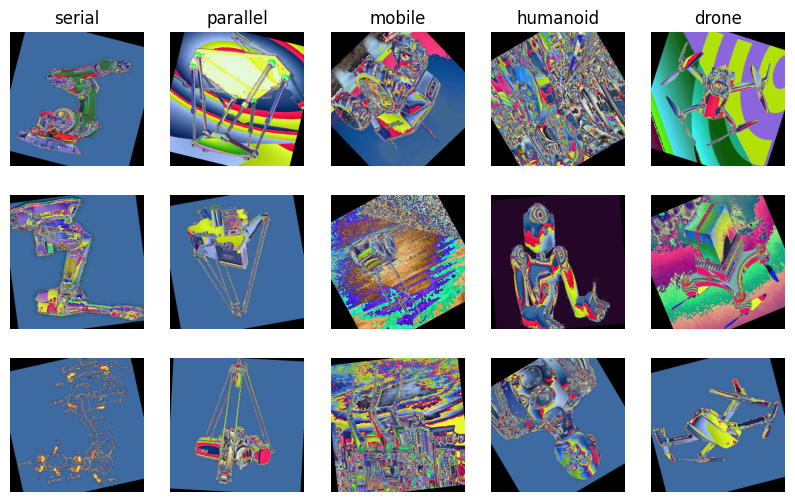

In [7]:
def show_first_n_images_per_class(dataset, n=1):
  classes = dataset.classes
  num_classes = len(classes)
  fig, axs = plt.subplots(n, num_classes, figsize=(num_classes * 2, n * 2))
  to_pil = transforms.ToPILImage()
  for i, class_name in enumerate(classes):
      class_indices = [idx for idx, (_, label) in enumerate(dataset.images) if label == i]
      class_indices = class_indices[:n]
      for j, idx in enumerate(class_indices):
          img_path, _ = dataset[idx]
          img_pil = to_pil(img_path)
          axs[j, i].imshow(np.asarray(img_pil))
          axs[j, i].axis('off')
          if j == 0:
              axs[j, i].set_title(class_name)
  plt.show()

show_first_n_images_per_class(dataset, n=3)

## Alternative Dataset Split
Here's an alternative route to split the dataset into the 3 mentioned groups and load the specified images to each group. Just like the previous method, the *batch-size* parameter is set to 30 for this project.

### DataLoader and Batchsize
The batch size is a hyperparameter in training Convolutional Neural Network (CNN) models that determines the number of samples processed in each iteration during training. The choice of batch size can have various effects on the training process and the performance of the CNN model. Here are some key considerations:

1. **Computational Efficiency:**
- Effect: Larger batch sizes generally lead to improved computational efficiency. This is because parallel processing capabilities of modern hardware, such as GPUs, can be more effectively utilized when processing larger batches of data simultaneously.
- Trade-off: However, extremely large batch sizes might not fit into GPU memory, limiting the potential for parallelism.
2. **Memory Usage:**
- Effect: Smaller batch sizes reduce the memory requirements during training, which can be crucial for models with limited memory resources. This is especially relevant when working with larger datasets or complex models.
- Trade-off: Larger batch sizes may require more memory, and if the batch size is too large, it might exceed the available GPU memory, leading to out-of-memory errors.
3. **Generalization and Stability:**
- Effect: Smaller batch sizes may introduce more noise into the optimization process, potentially making the training process less stable. However, this can sometimes lead to better generalization, especially when the dataset is small.
- Trade-off: Larger batch sizes provide more stable updates but might lead to a model that is less robust and generalizes less well, especially when the training set is not representative of the overall data distribution.
4. **Convergence Speed:**
- Effect: Larger batch sizes can lead to faster convergence during training due to more accurate gradient estimates. This is often observed in practice, where larger batches can lead to fewer parameter updates per epoch but faster overall training.
- Trade-off: Smaller batch sizes might require more iterations (epochs) to converge, but they might yield better convergence in terms of finding more optimal solutions.

In [8]:
train_datasets, validation_datasets, test_datasets = [], [], []
train_dist, validation_dist, test_dist = [], [], []

dists = [0] + dataset.class_dist
boundaries = []
for i in range(len(dists)-1):
  boundaries.append((sum(dists[:i+1]), sum(dists[:i+2])))

for class_start, class_end in boundaries:
  class_size = class_end - class_start
  train_size = int(0.7 * class_size)
  train_dist.append(train_size)
  validation_size = int(0.15 * class_size)
  validation_dist.append(validation_size)
  test_size = class_size - train_size - validation_size
  test_dist.append(test_size)
  indices = list(range(class_start, class_end))
  random.shuffle(indices)
  train_indices = indices[:train_size]
  validation_indices = indices[train_size:test_size]
  test_indices = indices[test_size:]
  train_datasets.append(Subset(dataset, train_indices))
  validation_datasets.append(Subset(dataset, validation_indices))
  test_datasets.append(Subset(dataset, test_indices))

train_loader = DataLoader(ConcatDataset(train_datasets), batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(ConcatDataset(validation_datasets), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(ConcatDataset(test_datasets), batch_size=BATCH_SIZE, shuffle=False)

## Dataset Diagnostic
Using a *Bar diagram*, we can have a glimpse of the statistics of the provided dataset.

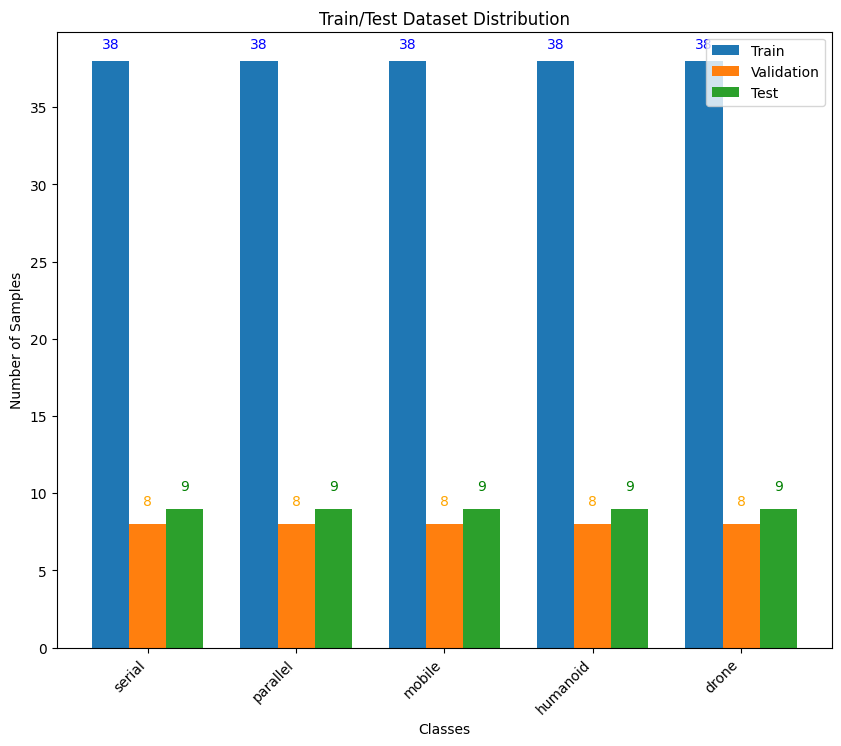

In [9]:
def plot_dataset_distribution(train_dist, validation_dist, test_dist, class_names):
  classes = np.arange(len(train_dist))
  fig, ax = plt.subplots(figsize=(10, 8))
  bar_width = 0.35
  train_bar = ax.bar(1.4*classes, train_dist, bar_width, label='Train')
  validation_bar = ax.bar(1.4*classes + bar_width, validation_dist, bar_width, label='Validation')
  test_bar = ax.bar(1.4*classes + 2*bar_width, test_dist, bar_width, label='Test')
  ax.set_xlabel('Classes')
  ax.set_ylabel('Number of Samples')
  ax.set_title('Train/Test Dataset Distribution')
  ax.set_xticks(1.4*classes + bar_width)
  ax.set_xticklabels(class_names, rotation=45, ha="right")
  ax.legend()
  for i, v in enumerate(train_dist):
      ax.text(1.4*i, v + 0.6, str(v), ha='center', va='bottom', fontsize=10, color='blue')
  for i, v in enumerate(validation_dist):
      ax.text(1.4*i + bar_width, v + 1, str(v), ha='center', va='bottom', fontsize=10, color='orange')
  for i, v in enumerate(test_dist):
      ax.text(1.4*i + 2*bar_width, v + 1, str(v), ha='center', va='bottom', fontsize=10, color='green')
  plt.show()

plot_dataset_distribution(train_dist, validation_dist, test_dist, dataset.classes)

## CNN Architucture
CNNs, or Convolutional Neural Networks, are a type of deep learning model designed for processing and analyzing visual data. They excel at capturing hierarchical patterns and features in images through convolutional layers, making them effective for tasks like image recognition and classification.


1.   `Number of Filters`:
    *   Specifies learnable convolutional filters applied to input data.
    *   Increases diversity of learned features but raises computational cost and parameters, potentially leading to overfitting.

2.   `Number of Neurons`:
    *   Determines learnable parameters and network capacity.
    *   Increasing neurons improves prediction but may lead to overfitting.
    *   Too few neurons may result in underfitting.

3.  `Depth of the Network`:
    *   Represents the number of layers in the network.
    *   Deeper networks capture more complex and abstract input representations.
    *   Challenges include vanishing gradients and increased computational cost.

4. `Kernel Size`:
    *   Refers to the dimensions of the filter in the convolutional layer.
    *   A smaller size captures local patterns, while a larger one captures global information.
    *   Impacts the receptive field, influencing the neuron's consideration of context.
    *   Larger sizes increase parameters and computational cost.

5. `Stride`:
    *   Determines the step size during the convolution operation.
    *   A larger stride reduces spatial dimensions; a smaller one preserves more spatial information.

6. `Padding`:
    *   Involves adding extra border pixels before convolution.
    *   Types:
        <ol type="a">
            <li><b>Valid Padding</b>: No padding, convolution on valid input positions.</li>
            <li><b>Same Padding</b>: Maintains output dimensions by padding to cover the entire input.</li>
        </ol>

7. `Activation Functions`:
    *   Introduce non-linearity for learning complex relationships.
    *   Common functions:
        <ol type="a">
        <li><b>ReLU</b>: $f(x)=\max (0, x)$; efficient but prone to "dying ReLU" problem.</li>
        <li><b>Leaky ReLU</b>: $f(x)=\max (a x, x)$ with a small constant 'a' to address dying ReLU.</li>
        <li><b>Sigmoid</b>: $f(x)=1 /\left(1+e^{-x}\right)$; suitable for binary classification but prone to vanishing gradient.</li>
        <li><b>Tanh</b>: $f(x)=\left(e^{2 x}-1\right) /\left(e^{2 x}+1\right)$; centered around zero, suitable for normalization.</li>
        <li><b>Softmax</b>: Used in output layer for multi-class classification, converts real numbers to probability distribution.</li>
        </ol>

Understanding and fine-tuning these parameters is crucial for optimizing neural network performance.

Although the architecture we're employing is a self-made original instance, it takes inspiration from the renowned *AlexNet*, with several enhancements for better feature extraction and model stability.


- **Convolutional Layer 1:** Initiating the process, this layer extracts fundamental features like edges, corners, and textures, utilizing 96 filters sized $11 \times 11$ with a stride of 4 .
- **Convolutional Layer 2:** Progressing beyond basic features, this layer focuses on capturing more intricate and advanced patterns.
- **Convolutional Layer 3:** Utilizing $3 \times 3$ filters, this layer refines features from the previous stage, extracting abstract information to bolster the model's grasp of complex patterns.
- **Convolutional Layer 4:** By applying $3 \times 3$ filters to the output from the third convolutional layer, not only does it contribute to pattern recognition, but it also introduces stability to the model.
- **Convolutional Layer 5:** Comprising $3 \times 3$ filters, this layer delves into extracting even more sophisticated features from the preceding stage.
- **Fully Connected Layers:** The final triad of fully connected layers assumes the responsibility of learning high-level representations and making predictions. The first two layers each house 4096 neurons, not only for their predictive prowess but also to enhance the model's stability. The last fully connected layer then produces class probabilities, representing the predicted labels.
- **Max Pooling Layers:** Strategically applied to reduce the spatial dimensions of the feature maps, facilitating information retention while mitigating computational complexity.
- **Average Pooling Layer:** Serving to further reduce spatial dimensions, this layer streamlines subsequent actions like flattening, effectively preventing potential processing bottlenecks.
- **Activation Functions:** The primary activation function here is ReLU, chosen for its simplicity, low computational cost, and its ability to maintain model elegance without unnecessary complexity.



In [10]:
class CNN(nn.Module):
  def __init__(self, num_classes=5):
    super(CNN, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(64, 192, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.classifier = nn.Sequential(
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classes),
    )
  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    # x = torch.nn.functional.softmax(x, dim=1)
    return x

model = CNN().to(device)

## Loss Function
Loss functions in Convolutional Neural Networks (CNNs) play a critical role in training the model by quantifying the difference between predicted values and actual target values. The choice of a suitable loss function depends on the specific nature of the task, such as classification or regression. Here are some commonly used loss functions in CNNs:

1. **Cross-Entropy Loss (or Log Loss):**
    - Task: Classification problems with multiple classes.
    - Use Case: Commonly used for image classification tasks where the model needs to assign a class label to an input image.
    - Explanation: Measures the dissimilarity between predicted probabilities and true class labels. It encourages the model to assign high probabilities to the correct class.
    $$
    \text { CrossEntropy }=-\sum_{i=1}^C \text { target }_i \log \left(\text { predicted }_i\right)
    $$
2. **Mean Squared Error (MSE) Loss:**
    - Task: Regression problems where the model predicts continuous values.
    - Use Case: Used when the goal is to predict a numerical value, such as age or price.
    - Explanation: Computes the average squared difference between predicted and true values. It penalizes larger errors more heavily than smaller ones.
    $$
    M S E=\frac{1}{n} \sum_{i=1}^n\left(\text { predicted }_i-\text { target }_i\right)^2
    $$
3. **Binary Cross-Entropy Loss:**
    - Task: Binary classification problems.
    - Use Case: Applicable when the output is binary (e.g., presence or absence of an object).
    - Explanation: Similar to cross-entropy loss but designed for binary classification. It measures the difference between predicted and true binary values.
    $$
    B C E=-(\text { target } * \log (\text { predicted })+(1-\text { target }) \log (1-\text { predicted }))
    $$
4. **Categorical Hinge Loss:**
    - Task: Multi-class classification problems.
    - Use Case: Suitable for classification tasks with multiple classes.
    - Explanation: Encourages correct class scores to be higher than incorrect class scores by a margin. Effective when there is a need for a margin between correct and incorrect class predictions.
5. **Huber Loss:**
    - Task: Regression problems.
    - Use Case: Combines aspects of mean squared error and mean absolute error. It is less sensitive to outliers compared to MSE.
    - Explanation: Reduces the impact of outliers by using quadratic loss for small errors and linear loss for larger errors.
6. **Negative Log-Likelihood Loss:**
    - Computes the negative log-likelihood loss for multi-class classification problems.
    - Suitable for multi-class classification problems where the targets are class labels.
$$
N L L L o s s=-\log \left(\text { predicted }_{\text {\{target\} }}\right)
$$

  
  
The choice of a loss function is influenced by the nature of the problem at hand and the desired characteristics of the model output. I have chosen **Cross-Entropy** Loss for several reasons: Its logarithmic nature provides higher penalties for confident and incorrect predictions, promoting faster and more effective learning. With a natural probabilistic interpretation, it aligns to maximize the likelihood of true class probabilities. Cross-Entropy Loss is well-suited for optimization algorithms, mitigating the vanishing gradient problem and ensuring efficient convergence. It extends seamlessly to multi-class problems, works compatibly with softmax activation, and acts as a form of regularization by discouraging overconfident incorrect predictions. While Cross-Entropy Loss is effective, the choice of a loss function depends on specific task characteristics, and experimentation may be needed to find the most suitable one for a given application.

## Optimizer
*Adam*, short for Adaptive Moment Estimation, is an optimization algorithm commonly used in training neural networks. It dynamically adjusts learning rates for each parameter based on historical gradients. It incorporates two moments: the mean (capturing the overall gradient trend) and the unbiased variance (capturing gradient variations). Adam initializes and updates these moments during training, with a bias correction mechanism to ensure accurate scaling. Its update rule combines momentum and RMSprop techniques, making it suitable for various neural network architectures and tasks. Adam efficiently handles sparse gradients and converges quickly, but its hyperparameters may require tuning. Overall, it's widely used in practice for its adaptive learning rates and robust performance.

### Comparison with SGD
`Adaptability: `
- Adam: Adapts learning rates individually for each parameter.
- SGD: Uses a fixed learning rate for all parameters.

`Efficiency:`
- Adam: More computationally expensive.
- SGD: Generally more computationally efficient.

`Sensitivity to Hyperparameters:`
- Adam: Less sensitive, but still requires tuning.
- SGD: Highly sensitive, and finding the right learning rate is crucial.

`Usage:`
- Adam: Commonly used in practice, especially for tasks with large datasets and complex models.
- SGD: Still used, particularly in scenarios where computational resources are limited or in simpler models.

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

## Training

In [12]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(NO_EPOCHS):
  correct_train = 0
  total_train = 0
  running_loss = 0.0
  for i,(inputs, labels) in enumerate(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    with torch.set_grad_enabled(True):
      outputs = model(inputs)
    error = criterion(outputs, labels.to(torch.long))
    running_loss += error.item()
    error.backward()
    optimizer.step()

    _, predicted = torch.max(outputs.data, 1)
    total_train += labels.size(0)
    correct_train += (predicted == labels).sum().item()


  train_accuracies.append(100 * correct_train / total_train)
  train_losses.append(running_loss / total_train)
  print(f'Epoch {epoch+1} : ')
  print(f'{Fore.BLUE}\tThe train accuracy : {(100 * correct_train / total_train):.2f} %')
  print(f'{Fore.RED}\tThe train loss : {(running_loss / total_train):.4f}')
  correct_test = 0
  total_test = 0
  running_loss = 0.0

  with torch.no_grad():
    for i,(inputs, labels) in enumerate(test_loader):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total_test += labels.size(0)
      correct_test += (predicted == labels).sum().item()

      error = criterion(outputs, labels.to(torch.long))
      running_loss += error.item()

      del inputs, labels, outputs

  test_accuracies.append(100 * correct_test / total_test)
  test_losses.append(running_loss / total_test)
  print(f'{Fore.BLUE}\tThe test accuracy : {(100 * correct_test / total_test):.2f} %')
  print(f'{Fore.RED}\tThe test loss : {(running_loss / total_test):.4f}')
  print(Style.RESET_ALL)

Epoch 1 : 
	The train accuracy : 21.05 %
	The train loss : 0.1453
	The test accuracy : 19.57 %
	The test loss : 0.0560

Epoch 2 : 
	The train accuracy : 20.53 %
	The train loss : 0.0606
	The test accuracy : 20.00 %
	The test loss : 0.0559

Epoch 3 : 
	The train accuracy : 18.95 %
	The train loss : 0.0596
	The test accuracy : 25.22 %
	The test loss : 0.0549

Epoch 4 : 
	The train accuracy : 27.89 %
	The train loss : 0.0580
	The test accuracy : 30.87 %
	The test loss : 0.0547

Epoch 5 : 
	The train accuracy : 27.89 %
	The train loss : 0.0561
	The test accuracy : 35.65 %
	The test loss : 0.0530

Epoch 6 : 
	The train accuracy : 35.26 %
	The train loss : 0.0529
	The test accuracy : 40.43 %
	The test loss : 0.0511

Epoch 7 : 
	The train accuracy : 39.47 %
	The train loss : 0.0515
	The test accuracy : 42.61 %
	The test loss : 0.0504

Epoch 8 : 
	The train accuracy : 44.21 %
	The train loss : 0.0492
	The test accuracy : 43.91 %
	The test loss : 0.0517

Epoch 9 : 
	The train accuracy : 39.47 %

## Plotting the Accuracy and Loss Trends

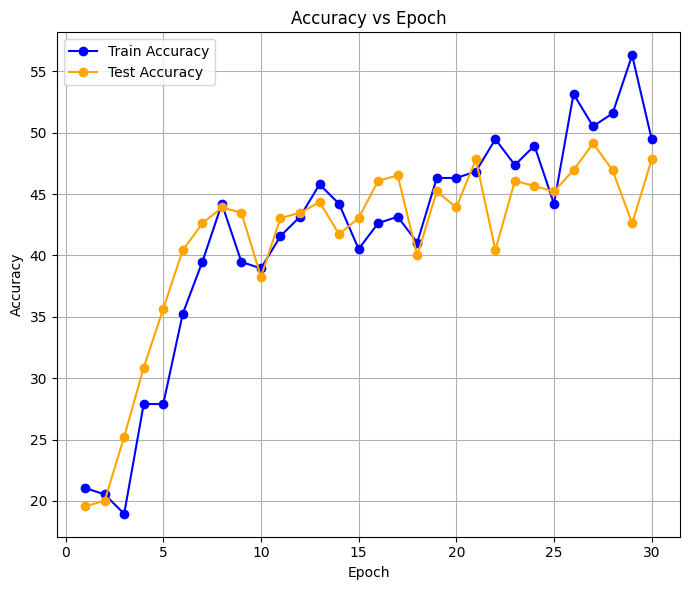

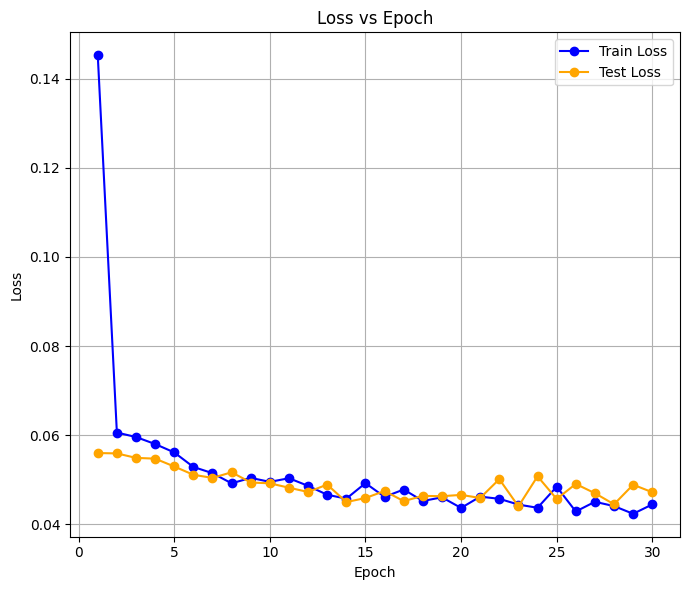

In [14]:
def plot_metric_vs_epoch(train_metric, test_metric, metric_name, epochs):
  fig, ax = plt.subplots(figsize=(7, 6))
  ax.plot(range(1, epochs+1), train_metric, label="Train " + metric_name, color="blue", marker="o")
  ax.plot(range(1, epochs+1), test_metric, label="Test " + metric_name, color="orange", marker="o")
  ax.set_xlabel('Epoch')
  ax.set_ylabel(metric_name)
  ax.set_title(f'{metric_name} vs Epoch')
  ax.legend()
  ax.grid()
  plt.tight_layout()
  plt.show()

plot_metric_vs_epoch(train_accuracies, test_accuracies, "Accuracy", NO_EPOCHS)
plot_metric_vs_epoch(train_losses, test_losses, "Loss", NO_EPOCHS)

## Final Results

Accuracy of the CNN is 43.478 %
Precision of the model is 45.468%
Recall of the model is 43.478%
F1_score of the model is 41.740%

We calculate metrics for each class:

	Accuracy for type serial is 79.565 %
	Precision for type serial is 48.276 %
	Recall for type serial is 30.435 %
	F1_score for type serial is 37.333 %

	Accuracy for type parallel is 74.783 %
	Precision for type parallel is 36.364 %
	Recall for type parallel is 34.783 %
	F1_score for type parallel is 35.556 %

	Accuracy for type mobile is 76.087 %
	Precision for type mobile is 40.426 %
	Recall for type mobile is 41.304 %
	F1_score for type mobile is 40.860 %

	Accuracy for type humanoid is 74.783 %
	Precision for type humanoid is 43.182 %
	Recall for type humanoid is 82.609 %
	F1_score for type humanoid is 56.716 %

	Accuracy for type drone is 81.739 %
	Precision for type drone is 59.091 %
	Recall for type drone is 28.261 %
	F1_score for type drone is 38.235 %



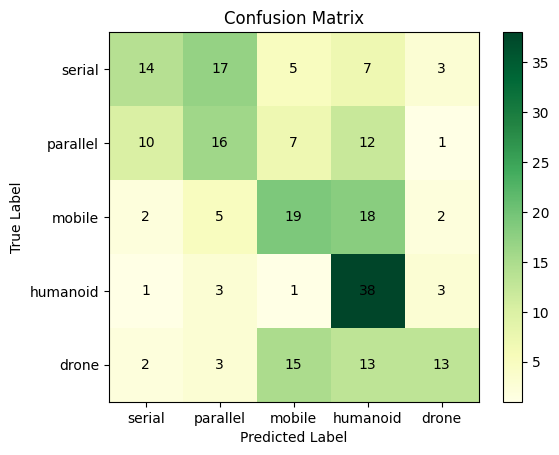

In [15]:
def plot_conf_matrix(conf_matrix, class_labels):
  plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.YlGn)
  plt.title('Confusion Matrix')
  plt.colorbar()
  plt.xticks(np.arange(len(class_labels)), class_labels)
  plt.yticks(np.arange(len(class_labels)), class_labels)
  for i in range(len(class_labels)):
      for j in range(len(class_labels)):
          plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

def seprate_data(y_pred, y_true, class_maps, label):
  seprated_y_true = []
  seprated_y_preds = []
  for i in range(len(y_true)):
      if y_true[i] == class_maps[label]:
          seprated_y_true.append(1)
      else:
          seprated_y_true.append(0)
      if y_pred[i] == class_maps[label]:
          seprated_y_preds.append(1)
      else:
          seprated_y_preds.append(0)
  return np.array(seprated_y_true), np.array(seprated_y_preds)

def calc_metrics(y_true, y_pred, dataset):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  print(f"Accuracy of the CNN is {100 * sk_metrics.accuracy_score(y_true, y_pred):.3f} %")
  print(f"Precision of the model is {100 * sk_metrics.precision_score(y_true, y_pred, average='macro'):.3f}%")
  print(f"Recall of the model is {100 * sk_metrics.recall_score(y_true, y_pred, average='macro'):.3f}%")
  print(f"F1_score of the model is {100 * sk_metrics.f1_score(y_true, y_pred, average='macro'):.3f}%\n")
  print("We calculate metrics for each class:\n")

  for class_label in dataset.classes:
    seprated_y_true, seprated_y_preds = seprate_data(y_pred, y_true, dataset.class_to_idx, class_label)
    print(f"\tAccuracy for type {class_label} is {100 * sk_metrics.accuracy_score(seprated_y_true, seprated_y_preds):.3f} %")
    print(f"\tPrecision for type {class_label} is {100 * sk_metrics.precision_score(seprated_y_true, seprated_y_preds):.3f} %")
    print(f"\tRecall for type {class_label} is {100 * sk_metrics.recall_score(seprated_y_true, seprated_y_preds):.3f} %")
    print(f"\tF1_score for type {class_label} is {100 * sk_metrics.f1_score(seprated_y_true, seprated_y_preds):.3f} %\n")
  plot_conf_matrix(sk_metrics.confusion_matrix(y_true, y_pred), dataset.classes)
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for i,(inputs, labels) in enumerate(test_loader):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      y_true += [_.item() for _ in list(labels)]
      y_pred += [_.item() for _ in list(predicted)]
calc_metrics(np.array(y_true),np.array(y_pred), dataset)